In [1]:
import numpy as np
import math
from typing import List
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
import scipy.integrate as integrate

class Particle():
    def __init__(self, position, property):
        self.position = position
        self.complex_position = self.position[0] + 1J * self.position[1]
        self.property = property
        self.acceleration = np.array([0.,0.,0.])
        self.velocity = np.array([0.,0.,0.])

class Mesh():
    def __init__(self, width, n_levels, expansion_order):
        self.width = width
        self.n_levels = n_levels
        self.expansion_order = expansion_order
        # A 3D array indexed [level][i][j]
        self.meshboxes = []
        self.initialise_mesh()
    
    def initialise_mesh(self):
        # Index main levels from 0, ie level 0 is only one box
        for level in range(0, self.n_levels+1):
            self.meshboxes.append([])
            for i in range(0, 2**level):
                self.meshboxes[level].append([])
                for j in range(0, 2**level):
                    self.add_meshbox(level, [i,j])
            for i in range(0, 2**level):
                for j in range(0, 2**level):
                    self.meshboxes[level][i][j].allocate_neighbours()
            for i in range(0, 2**level):
                for j in range(0, 2**level):
                    self.meshboxes[level][i][j].calc_i_list()
            


    def add_meshbox(self, level, level_coords):
        if level-1 > -1:
            new_meshbox_parent = self.meshboxes[level-1][int(level_coords[0]/2)][int(level_coords[1]/2)]
            new_meshbox = MeshBox(self, new_meshbox_parent, level, level_coords)
            new_meshbox_parent.children.append(new_meshbox)
        else:
            new_meshbox = MeshBox(self, None, level, level_coords)
        
        self.meshboxes[level][level_coords[0]].append(new_meshbox)
    
    def add_particle(self, particle: Particle):
        fine_level_coords = np.int64(np.floor(particle.position/self.width * 2**self.n_levels))
        self.meshboxes[self.n_levels][fine_level_coords[0]][fine_level_coords[1]].add_particle(particle)
    
    def calc_fine_mpes(self):
        for meshbox in list(np.concatenate(self.meshboxes[self.n_levels]).flat):
            meshbox.calc_fine_mpe()
    
    def calc_coarse_mpes(self):
        for level in reversed(range(0, self.n_levels)):
            for meshbox in list(np.concatenate(self.meshboxes[level]).flat):
                meshbox.calc_coarse_mpe()
    
    def calc_local_expansions(self):
        for level in range(1, self.n_levels+1): # From 1...n-1
            for meshbox in list(np.concatenate(self.meshboxes[level]).flat):
                meshbox.calc_local_expansion()
            if level < self.n_levels +1:
                for meshbox in list(np.concatenate(self.meshboxes[level]).flat):
                    meshbox.translate_le_to_children()
    
    def calc_le_particle_potentials(self):
        for meshbox in list(np.concatenate(self.meshboxes[self.n_levels]).flat):
            meshbox.evaluate_particle_les()
    
    def calc_neighbour_particle_potentials(self):
        for meshbox in list(np.concatenate(self.meshboxes[self.n_levels]).flat):
            meshbox.evaluate_neighbour_potentials()
    
    def plot_potential(self):
        xs = []
        ys = []
        potentials = []
        for particle in self.meshboxes[0][0][0].particles:
            position = particle.position
            xs.append(position[0])
            ys.append(position[1])
            potentials.append(particle.total_potential)
        fig, ax = plt.subplots()
        ax.tricontour(xs, ys, potentials, levels=4, colors='k')
        cntr = ax.tricontourf(xs, ys, potentials, levels=100, cmap="RdBu_r")
        fig.colorbar(cntr, ax=ax)
            
            

class MeshBox():
    def __init__(self, mesh: Mesh, parent, level, level_coords):
        self.mesh = mesh
        self.level = level
        self.level_coords = level_coords
        self.width = mesh.width / (2 ** level)
        self.children = []
        self.parent = parent
        self.particles = []
        self.centre = (np.array(level_coords) + np.array([0.5, 0.5])) / 2**level * mesh.width
        self.complex_centre = self.centre[0] + 1j*self.centre[1]
        self.i_list : List[MeshBox] = []
        self.neighbours = []
    
    def allocate_neighbours(self):
        neighbour_list = []
        for i in range(-1,2):
            for j in range(-1,2):
                if self.level_coords[0]+i > -1 and self.level_coords[1]+j > -1 and self.level_coords[0]+i < 2**self.level and self.level_coords[1]+j < 2**self.level:
                    neighbour_list.append(self.mesh.meshboxes[self.level][self.level_coords[0]+i][self.level_coords[1]+j])
        neighbour_list.remove(self)
        self.neighbours = neighbour_list
    
    def calc_i_list(self):
        i_list = [] # Interaction list
        if self.parent != None:
            for parent_neighbour in self.parent.neighbours:
                i_list += parent_neighbour.children
            for own_neighbour in self.neighbours:
                if own_neighbour in i_list:
                    i_list.remove(own_neighbour)
            self.i_list = i_list
    
    def add_particle(self, particle: Particle):
        self.particles.append(particle)
        if self.parent != None:
            self.parent.add_particle(particle)
    
    def calculate_total_property(self):
        self.property_total = sum([particle.property for particle in self.particles])
        return self.property_total
    
    def calc_fine_mpe(self):
        coefficients = [self.calculate_total_property()]
        if self.mesh.expansion_order < 0:
            raise Exception("For multipole expansion, p must be greater than 0")
        for exponent in range(1, self.mesh.expansion_order+1):
            coefficient = 0
            for particle in self.particles:
                coefficient += (-particle.property * abs(particle.complex_position - self.complex_centre) ** exponent) / exponent
                #print((particle.complex_position - self.complex_centre))
                #print(f'particle {particle.complex_position}')
                #print(f'box {self.complex_centre}')
            coefficients.append(coefficient)
        # Includes a_0 (Q) up to a_n
        self.mpe_coefficients = coefficients
        #print("fine", self.level, self.level_coords, self.centre)
        #print(coefficients)
        #if coefficients[0] != 0:
         #   print(self)
    
    def calc_coarse_mpe(self):
        shift_coeffs = np.zeros(self.mesh.expansion_order+1)
        for child_meshbox in self.children:
            child_coeffs = child_meshbox.mpe_coefficients
            # Initialise the array and include the (unchanged) a_0
            child_shift_coeffs = [child_coeffs[0]]
            # Calculates the remaining b_l
            #print("coarse", self.level, self.level_coords, self.centre)
            for shift_exponent in range(1, self.mesh.expansion_order + 1):
                child_shift_coeff = 0
                for k in range(1, shift_exponent+1):
                    z_0 = abs(child_meshbox.complex_centre - self.complex_centre)
                    child_shift_coeff += child_coeffs[k] * (z_0) ** (shift_exponent-k) * math.comb(shift_exponent-1, k-1)
                #print(child_shift_coeff)
                child_shift_coeff += (-child_coeffs[0] * z_0 ** shift_exponent) / shift_exponent
                #print(child_shift_coeff)
                child_shift_coeffs.append(child_shift_coeff)
            #print(child_shift_coeffs)
                
            #print(len(shift_coeffs))
            #print(len(child_shift_coeffs))
            shift_coeffs += child_shift_coeffs
        self.mpe_coefficients = shift_coeffs
        
        #print(shift_coeffs)
        #print(shift_coeffs)
        #print(shift_coeffs)

    def calc_local_expansion(self):
        if self.level == 1:
            le_coeffs = np.zeros(self.mesh.expansion_order+1) # Local expansion coefficients
        else:
            le_coeffs = self.le_coeffs
            #print("Starting with old", le_coeffs)

        for i_box in self.i_list:
            z_0 = abs(i_box.complex_centre - self.complex_centre)
            # Calculating b_0
            b_0 = 0
            for k in range(1, self.mesh.expansion_order+1):
                b_0 += i_box.mpe_coefficients[k]/(z_0**k) * (-1)**k
            b_0 += i_box.mpe_coefficients[0] * (np.log(z_0))
            le_coeffs[0] += b_0
            for l in range(1, self.mesh.expansion_order+1):
                b_l = 0
                for k in range(1,self.mesh.expansion_order+1):
                    #print(l, k)
                    b_l += 1/(z_0**l) * i_box.mpe_coefficients[k] / (z_0**k) * math.comb(l+k-1, k-1) * ((-1)**k)
                b_l -= i_box.mpe_coefficients[0]/(l*(z_0**l))
                le_coeffs[l] += b_l
        self.le_coeffs = le_coeffs
        #print("local", self.level, self.level_coords, self.centre)
        #print(le_coeffs)
        #print(le_coeffs)
        #print(self.level)
        #print(le_coeffs)
    
    def translate_le_to_children(self):
        for child_box in self.children:
            z_0 = child_box.complex_centre - self.complex_centre
            child_le_coeffs = np.zeros(self.mesh.expansion_order+1)
            for l in range(0, self.mesh.expansion_order+1):
                for k in range(l, self.mesh.expansion_order+1):
                    child_le_coeffs[l] += self.le_coeffs[k] * math.comb(k,l) * (-abs(z_0))**(k-l)
            child_box.le_coeffs = child_le_coeffs
            #print(child_le_coeffs)

    def evaluate_particle_les(self):
        for particle in self.particles:
            particle.le_potential = self.evaluate_le(particle)
    
    def evaluate_le(self, particle: Particle):
        le_potential = 0
        z = particle.complex_position - self.complex_centre
        for l in range(0, self.mesh.expansion_order+1):
            le_potential += self.le_coeffs[l] * abs(z)**l
        #print(le_potential)
        return -le_potential
    
    def evaluate_neighbour_potentials(self):
        box_particles = self.particles
        interaction_particles = []
        interaction_particles += box_particles 
        for neighbour in self.neighbours:
            interaction_particles += neighbour.particles
        for box_particle in box_particles:
            particle_neighbour_potential = 0
            for neighbour_particle in interaction_particles:
                if neighbour_particle != box_particle:
                    particle_neighbour_potential += neighbour_particle.property * np.real(-np.log(box_particle.complex_position - neighbour_particle.complex_position))
            box_particle.neighbour_potential = particle_neighbour_potential
            box_particle.total_potential = box_particle.neighbour_potential + box_particle.le_potential
            box_particle.real_potential = box_particle.total_potential


                


        
            
            

            

    
    

# Gives distance from point 1 to point 2
def distance(point_1, point_2):
    return np.linalg.norm(point_2-point_1)
        



n_levels 7
p 6


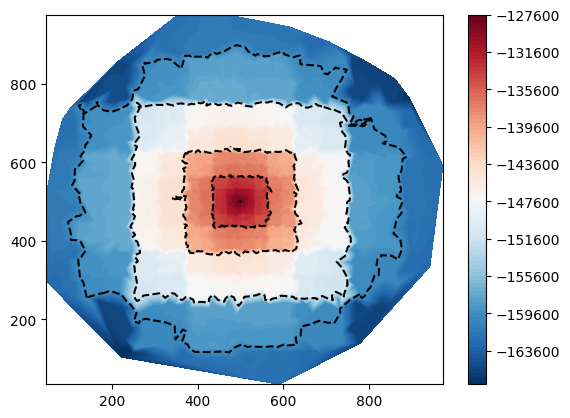

In [2]:
n_particles = 5000
precision = 40
box_size = 1000
# property could be mass or charge 
np.random.seed(100)
max_property = 10
n_levels = int(np.ceil(np.emath.logn(4, n_particles)))
p = int(np.ceil(np.log2(precision)))
print(f'n_levels {n_levels}')
print(f'p {p}')
# initial_radii = np.random.beta(1,2,(n_particles)) * box_size/2
# initial_angles = np.random.uniform(0,2*np.pi,(n_particles))
# initial_xs = initial_radii * np.cos(initial_angles) + box_size/2
# initial_ys = initial_radii * np.sin(initial_angles) + box_size/2
# initial_positions = np.array([initial_xs, initial_ys]).transpose()
initial_positions = np.random.beta(2,2,(n_particles,2)) * box_size

initial_particles = []
for initial_position in initial_positions:
    initial_particles.append(Particle(initial_position, np.random.uniform(0,max_property)))
#initial_particles.append(Particle([box_size/2, box_size/2], 100))
#n_particles += 1

# Initialisaiton
mesh = Mesh(box_size, n_levels, p)
for particle in initial_particles:
    mesh.add_particle(particle)
    #print(particle.property)

# FMM
mesh.calc_fine_mpes() # Step 1
mesh.calc_coarse_mpes() # Step 2
mesh.calc_local_expansions() # Step 3 and 4
mesh.calc_le_particle_potentials() # Step 5
mesh.calc_neighbour_particle_potentials() # Step 6 and 7
mesh.plot_potential()






In [3]:
# print(mesh.meshboxes[1][0][1].level_coords)
# print(mesh.meshboxes[4][3][3].parent.parent.parent.parent.parent)
# print(len(mesh.meshboxes))
# for meshbox in mesh.meshboxes:
#     print(len(meshbox))
# print(len(mesh.meshboxes[7][1][3].particles))
# for i in range(0,50):
#     print(mesh.meshboxes[7][5][i].mpe_coefficients)
#     print(mesh.meshboxes[7][5][i].calculate_total_property())
# print(mesh.meshboxes[0][0][0].particles[0].position)
# for meshbox in mesh.meshboxes[5][31][31].i_list:
#     if meshbox.particles != []:
#         print(meshbox)
#         for particle in meshbox.particles:
#             print(particle.total_potential)
#     #print(meshbox.particle)
# mesh.plot_potential()
#mesh.plot_potential_hist()


[-4.54671661e+03 -5.66859342e-04 -5.91831972e+03  1.00000000e+00
  1.00000000e+00]
[0.030592213856310536, 0.04382914619193907, 0.05068205838488788, 0.19106044200922126, 0.21394411093729893, 0.24971032368881732, 0.2771641564025008, 0.28714599923866124, 0.29895314423493896, 0.36456631381060595, 0.3821924051618821, 0.39794658370849306, 0.4015649341537452, 0.412197123888573, 0.43736053022872606, 0.5297846021827203, 0.5379064917103575, 0.5491075906808948, 0.5534061611061871, 0.6128969611314848, 0.6403764127554904, 0.7428795506582245, 0.8483882914922978, 0.8717428877111533, 0.908808573605145, 0.9097902055174277, 0.9884428425139908, 1.0011017156814004, 1.1183945074827724, 1.1713440709170095, 1.1846275448644894, 1.2566411425258832, 1.2631253720140287, 1.2716224825617026, 1.3331597768353687, 1.516627605806402, 1.5201310754004647, 1.5601274512290042, 1.6166380012831991, 1.6581082079573277, 1.720713159795463, 1.7476810861709213, 1.8349348590251946, 1.8588480745136022, 1.8741029575839474, 1.876789

/var/folders/kx/94yhyxhd7fz53_m_dcz_84nr0000gn/T/ipykernel_1128/1489540499.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b*(x-c))
/var/folders/kx/94yhyxhd7fz53_m_dcz_84nr0000gn/T/ipykernel_1128/1489540499.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, sim_rs, sim_potentials)


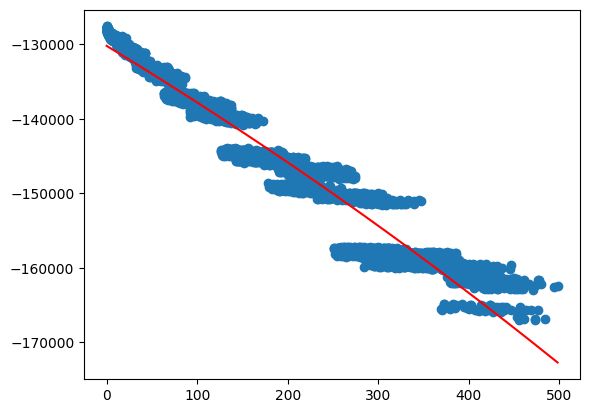

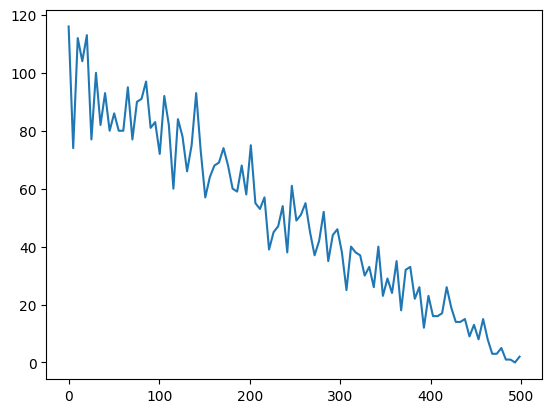

In [4]:
def func(x, a, b, c, d, e):
    return a * np.exp(-b*(x-c))
sim_rs=[]
sim_potentials = []
for particle in mesh.meshboxes[0][0][0].particles:
    position = particle.position
    sim_potentials.append(particle.total_potential)
    r = np.sqrt((position[0]-box_size/2)**2 + (position[1]-box_size/2)**2)
    sim_rs.append(r)
popt, pcov = curve_fit(func, sim_rs, sim_potentials)
fig, ax = plt.subplots()
ax.scatter(sim_rs, sim_potentials)
print(popt)
ax.plot(sorted(sim_rs), func(np.array(sorted(sim_rs)), *popt), 'r-')
his = np.histogram(sorted(sim_rs),100)[0]
print(sorted(sim_rs))
print(his)
plt.figure()
plt.plot(np.linspace(0,max(sim_rs), 100), his)

/var/folders/kx/94yhyxhd7fz53_m_dcz_84nr0000gn/T/ipykernel_1128/3692847817.py:9: RuntimeWarning: divide by zero encountered in divide
  return p(r) / (2 * np.pi * r) * max_property/2 * n_particles
/Users/thomashartigan/Documents/Uni/part II/Computing_Project/.computing_project_venv/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


50
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


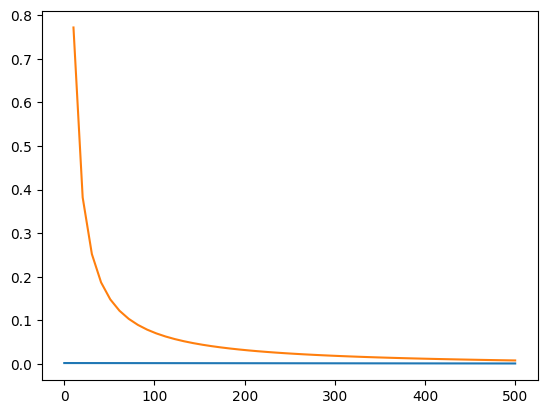

In [5]:
calc_rs = np.linspace(0,box_size/2,50)
def p(r):
    #print(box_size)
    return 2 / (box_size**2) * (box_size-r)

plt.plot(calc_rs, p(calc_rs))

def sigma(r, theta):
    return p(r) / (2 * np.pi * r) * max_property/2 * n_particles

def potential_func(r, theta, r_0):
    return -1/(2*np.pi)*r*sigma(r, theta)*(1/2 * np.log(r**2 + r_0**2-2*r*r_0*np.cos(theta)))

plt.plot(calc_rs, sigma(calc_rs, 0))
calc_potentials1 = []

print(len(calc_rs))
i=0
for eval_r in calc_rs:
    i+=1
    print(i)
    calc_potentials1.append(integrate.dblquad(potential_func, 0, box_size, 0, 2*np.pi, args=[eval_r])[0])




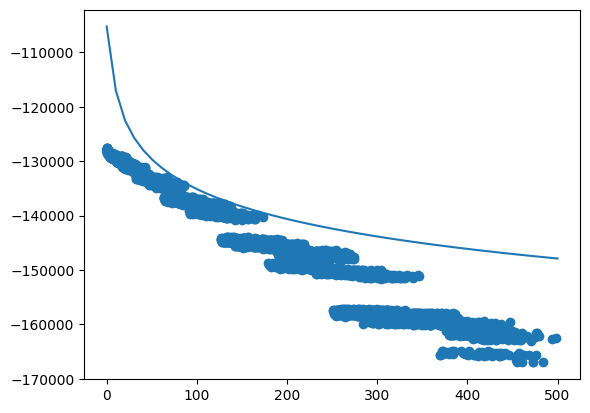

In [6]:

fig2, ax2 = plt.subplots()
ax2.plot(calc_rs, (np.array(calc_potentials1) + 2*min(calc_potentials1)))
ax2.scatter(sim_rs, sim_potentials)
#print(potentials)


# Single Charged Particle

n_levels 7
p 10


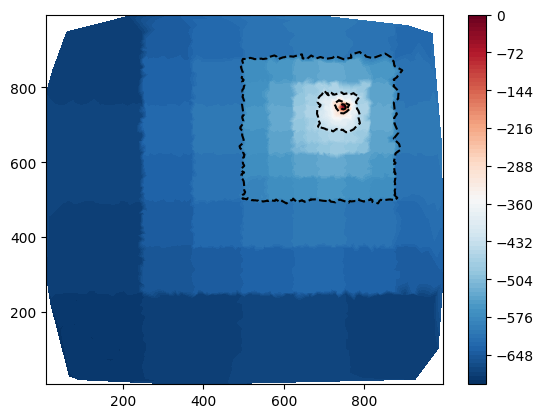

In [22]:
n_particles = 10000
#precision = #1000
box_size = 1000
# property could be mass or charge 
max_property = 0
n_levels = int(np.ceil(np.emath.logn(4, n_particles)))
p = 10#int(np.ceil(np.log2(precision)))
print(f'n_levels {n_levels}')
print(f'p {p}')
#initial_radii = np.random.uniform(0,1,(n_particles)) * box_size/2
#initial_angles = np.random.uniform(0,2*np.pi,(n_particles))
#initial_xs = initial_radii * np.cos(initial_angles) + box_size/2
#initial_ys = initial_radii * np.sin(initial_angles) + box_size/2
#initial_positions = np.array([initial_xs, initial_ys]).transpose()
initial_positions = np.random.beta(2,2,(n_particles,2)) * box_size
initial_particles = []
for initial_position in initial_positions:
    initial_particles.append(Particle(initial_position, np.random.uniform(0,max_property)))
#initial_particles.append(Particle(np.array([622.3, 339.7]), 100))
initial_particles.append(Particle(np.array([749.9, 749.9]), 100))
#n_particles += 1

# Initialisaiton
mesh2 = Mesh(box_size, n_levels, p)
for particle in initial_particles:
    mesh2.add_particle(particle)
    #print(particle.property)

# FMM
mesh2.calc_fine_mpes() # Step 1
mesh2.calc_coarse_mpes() # Step 2
mesh2.calc_local_expansions() # Step 3 and 4
mesh2.calc_le_particle_potentials() # Step 5
mesh2.calc_neighbour_particle_potentials() # Step 6 and 7
mesh2.plot_potential()


In [23]:
particle_box = mesh.meshboxes[2][2][1]
print(particle_box.level, particle_box.centre, particle_box.level_coords, particle_box.mpe_coefficients)


2 [625. 375.] [2, 1] [ 4.78617526e+03 -8.33949415e+05 -7.26571190e+07 -8.44058771e+09
 -1.10315617e+12 -1.53796791e+14 -2.23359030e+16]


[-79.08042214 160.4596875  -79.08042071   1.           1.        ]
[0.0, 4.579113168337135, 9.035943056920603, 10.429707102354385, 12.410575572930169, 14.038025378828419, 14.665340571055292, 15.71440209489419, 15.947497242354103, 16.332638124642884, 16.62170902462814, 16.96177812072546, 17.841854898723966, 17.877294809252078, 19.69887198039626, 20.35100015227077, 21.512650931099138, 22.547875267372156, 23.776855702404916, 23.898892909570154, 25.27733995523442, 25.435789375612373, 25.468804578190376, 26.190522047692376, 26.439529019862494, 26.471173888469554, 26.6649692057888, 27.061848646048375, 27.37788592276029, 27.394672822350067, 27.721144700952653, 28.364383415032087, 28.723495408193386, 28.769278176517027, 28.77764500609581, 29.119325857407677, 29.51306230584106, 29.84408815094598, 30.649656057074, 30.991982028546264, 31.00988218176459, 31.5328542711133, 32.69100951971344, 32.78060169117944, 33.03907266681761, 33.695887049400156, 33.74149254449036, 33.815914526644036, 34.36405809

/var/folders/kx/94yhyxhd7fz53_m_dcz_84nr0000gn/T/ipykernel_1128/2463633316.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(func, sim_rs, sim_potentials)
/var/folders/kx/94yhyxhd7fz53_m_dcz_84nr0000gn/T/ipykernel_1128/2463633316.py:15: RuntimeWarning: divide by zero encountered in log
  ax3.plot(sorted(sim_rs), -100*np.log(sorted(sim_rs)), 'r-')


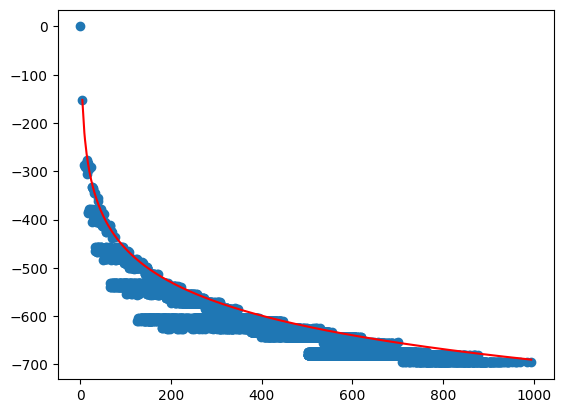

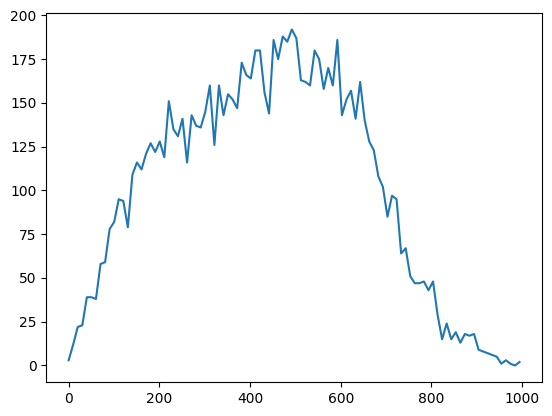

In [28]:
def func(x, a, b, c, d, e):
    return a * np.exp(-b*(x-c))
sim_rs=[]
sim_potentials = []
for particle in mesh2.meshboxes[0][0][0].particles:
    position = particle.position
    sim_potentials.append(particle.total_potential)
    r = np.sqrt((position[0]-749.9)**2 + (position[1]-749.9)**2)
    sim_rs.append(r)
popt, pcov = curve_fit(func, sim_rs, sim_potentials)
fig3, ax3 = plt.subplots()
ax3.scatter(sim_rs, sim_potentials)
print(popt)
#ax.plot(sorted(sim_rs), func(np.array(sorted(sim_rs)), *popt), 'r-')
ax3.plot(sorted(sim_rs), -100*np.log(sorted(sim_rs)), 'r-')
his = np.histogram(sorted(sim_rs),100)[0]
print(sorted(sim_rs))
print(his)
plt.figure()
plt.plot(np.linspace(0,max(sim_rs), 100), his)

/var/folders/kx/94yhyxhd7fz53_m_dcz_84nr0000gn/T/ipykernel_1128/3010297987.py:10: RuntimeWarning: divide by zero encountered in divide
  return p(r) / (2 * np.pi * r) * max_property/2 * n_particles
/var/folders/kx/94yhyxhd7fz53_m_dcz_84nr0000gn/T/ipykernel_1128/3010297987.py:10: RuntimeWarning: invalid value encountered in multiply
  return p(r) / (2 * np.pi * r) * max_property/2 * n_particles


50
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


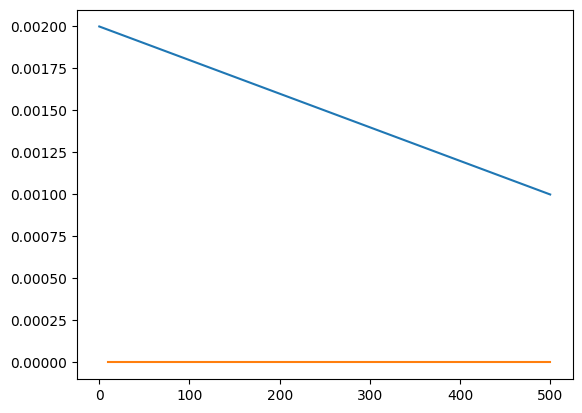

In [29]:
calc_rs = np.linspace(0,box_size/2,50)
def p(r):
    #print(box_size)
    return 2 / (box_size**2) * (box_size-r)

plt.plot(calc_rs, p(calc_rs))

def sigma(r, theta):
    
    return p(r) / (2 * np.pi * r) * max_property/2 * n_particles

def potential_func(r, theta, r_0):
    return -1/(2*np.pi)*r*sigma(r, theta)*(1/2 * np.log(r**2 + r_0**2-2*r*r_0*np.cos(theta)))

plt.plot(calc_rs, sigma(calc_rs, 0))
calc_potentials = []

print(len(calc_rs))
i=0
for eval_r in calc_rs:
    i+=1
    print(i)
    calc_potentials.append(integrate.dblquad(potential_func, 0, box_size, 0, 2*np.pi, args=[eval_r])[0])


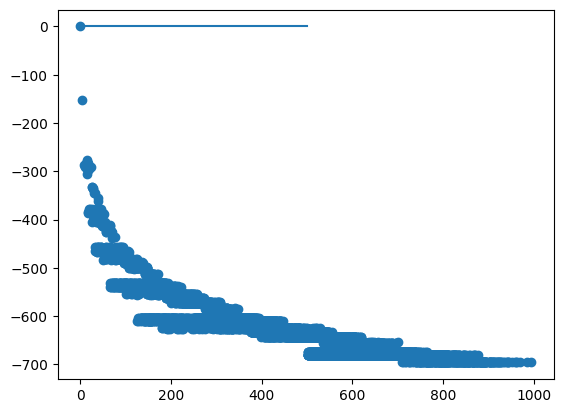

In [30]:
fig4, ax4 = plt.subplots()
ax4.plot(calc_rs, (np.array(calc_potentials)-min(calc_potentials)))
ax4.scatter(sim_rs, sim_potentials)
#print(potentials)